<a href="https://colab.research.google.com/github/matdcp/Data-dreamers-/blob/main/NEURAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Upload cleaned dataset


In [ ]:
import pandas as pd
from google.colab import files

# Carica il file CSV
uploaded = files.upload()


Saving cleaned_dataset_NN.csv to cleaned_dataset_NN.csv


In [ ]:
# Leggi il file CSV con Pandas
for filename in uploaded.keys():
    df = pd.read_csv(filename)

df.head()

id  Start  End                     Label
0   Ventricular      0   11  B-Multi-tissue_structure
1  fibrillation     12   24                         O
2          long     32   36                         O
3            QT     37   39                         O
4      syndrome     40   48                         O

#Goal
This notebook focuses on the sequential classification of textual tokens, drawing inspiration from **Named Entity Recognition (NER)** tasks, using BIO-structured labels to categorize entities in the anatomical domain. Four models will be implemented: **LinearSVC**, which leverages a linear approach with the One-vs-Rest method; **LSTM**, designed to capture long-term dependencies between tokens; **BiLSTM**, which accounts for bidirectional context; and **GRU**, an efficient alternative to LSTM. Each model will be evaluated based on its ability to correctly identify entities and assign labels to the predefined categories.

#Data preprocessing

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.svm import LinearSVC
from sklearn import metrics
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, LSTM, GRU, Dense, Dropout, TimeDistributed, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from IPython.display import display
from scipy.stats import mode
import tensorflow as tf



In [ ]:
# Definizione dei gruppi di token e delle etichette**
sequence_length = 10  # Definisci il numero di token per frase
df['Group'] = df.index // sequence_length  # Crea un gruppo ogni 10 token

# Gruppo delle sequenze e delle etichette
sentences = df.groupby('Group')['id'].apply(list).tolist()  # Liste di token per gruppo
labels = df.groupby('Group')['Label'].apply(list).tolist()  # Liste di etichette per gruppo

#Tokenizzazione delle sequenze**
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(sentences)  # Addestra il tokenizer sulle sequenze di token

# Converti i token in ID numerici
X = tokenizer.texts_to_sequences(sentences)

#Codifica delle etichette con LabelEncoder**
# Addestra il LabelEncoder su tutte le etichette del dataset
label_encoder = LabelEncoder()
label_encoder.fit(df['Label'])  # Usa tutte le etichette presenti nella colonna 'Label'

# Converte le etichette in ID numerici per ogni frase
y = [label_encoder.transform(sentence) for sentence in labels]

#Applicazione del padding**
# Lunghezza massima delle sequenze (per token e etichette)
max_sequence_len = 10  # Usa 10 come lunghezza massima (già definita)

# Applica il padding alle sequenze di token
X_padded = pad_sequences(X, maxlen=max_sequence_len, padding='post')

# Applica il padding alle sequenze di etichette
y_padded = pad_sequences(y, maxlen=max_sequence_len, padding='post')

# **5. Verifiche**
print(f"Shape di X_padded: {X_padded.shape}")
print(f"Shape di y_padded: {y_padded.shape}")

# Esempio di sequenze
print("\nEsempio di sequenza tokenizzata e con padding (X_padded):")
print(X_padded[:3])  # Mostra le prime 3 sequenze

# Esempio di etichette
print("\nEsempio di etichette con padding (y_padded):")
print(y_padded[:3])  # Mostra le prime 3 etichette

# Visualizza i token originali per la prima sequenza
print("\nToken originali per la prima sequenza (X_padded):")
print([tokenizer.index_word[idx] for idx in X_padded[0] if idx != 0])  # Ignora i padding (0)

# Visualizza le etichette originali per la prima sequenza
print("\nEtichette originali per la prima sequenza (y_padded):")
original_labels = [
    label_encoder.inverse_transform([idx])[0] for idx in y_padded[0] if idx != 0
]
print(original_labels)


Shape di X_padded: (6098, 10)
Shape di y_padded: (6098, 10)

Esempio di sequenza tokenizzata e con padding (X_padded):
[[1187 2898  309 1740  259 2026  463 2899 2900 1740]
 [  36  397 6456  432   58  886  819 6457  887  888]
 [ 173 1740   36  397 2900   49 2899  525  889 1187]]

Esempio di etichette con padding (y_padded):
[[ 5 22 22 22 22 22 22 22 22 22]
 [22 22 22 22 22 22 22 22 22 22]
 [22 22 22 22 22 22 22 22 22  5]]

Token originali per la prima sequenza (X_padded):
['ventricular', 'fibrillation', 'long', 'qt', 'syndrome', 'probably', 'caused', 'clindamycin', 'prolongation', 'qt']

Etichette originali per la prima sequenza (y_padded):
['B-Multi-tissue_structure', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


We prepared the data for a sequential classification model. We divided the tokens into fixed-length groups (10 tokens per sequence), creating a list of sequences and corresponding labels for each group. For the tokens, we applied tokenization to convert them into numerical IDs, handling unknown words with the <OOV> token. The labels were transformed into consistent numerical IDs using a LabelEncoder trained on all labels in the dataset. Next, we standardized the token and label sequences to a fixed length of 10 using post-padding, ensuring compatibility with the model. Finally, we validated the results by displaying examples of tokenized and padded sequences, as well as decoding the original tokens and labels for verification.

#Splitting dataset

We allocate 70% of the dataset for training, 15% for testing, and the remaining 15% for validation. This ensures a balanced approach, with a majority of the data used for model learning, while reserving sufficient portions for unbiased performance evaluation and hyperparameter tuning.

In [ ]:
# Esegui lo split su X_padded e y_padded
X_train, X_temp, y_train, y_temp = train_test_split(X_padded, y_padded, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Train set: X={X_train.shape}, y={y_train.shape}")
print(f"Validation set: X={X_val.shape}, y={y_val.shape}")
print(f"Test set: X={X_test.shape}, y={y_test.shape}")

Train set: X=(4268, 10), y=(4268, 10)
Validation set: X=(915, 10), y=(915, 10)
Test set: X=(915, 10), y=(915, 10)


#Rebalancing dataset

We computed class weights to address the **dataset's imbalance**. The labels were flattened into a one-dimensional array to calculate the relative frequency of each class, and unique class labels were identified. Each class was then assigned a weight inversely proportional to its frequency, ensuring that underrepresented classes are given higher weights. For example, class 0 has a weight of 47.58, reflecting its low frequency, whereas class 22, with a weight of 0.047, is the most frequent class. These weights will be applied during **training** to promote balanced learning and mitigate the risk of bias toward more frequent classes.

In [ ]:
# Converti y_train in un array 1D per calcolare i pesi
y_train_flat = y_train.flatten()
unique_labels = np.unique(y_train_flat)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=unique_labels,
    y=y_train_flat
)

class_weights_dict = dict(enumerate(class_weights))
print("Pesi delle classi:", class_weights_dict)

Pesi delle classi: {0: 47.58082497212932, 1: 3.3495526604928583, 2: 13.446754883427852, 3: 88.36438923395445, 4: 40.34026465028355, 5: 4.034026465028355, 6: 7.277067348678602, 7: 14.727398205659075, 8: 8.921404682274247, 9: 7.277067348678602, 10: 15.860274990709774, 11: 92.78260869565217, 12: 5.674777290253956, 13: 36.38533674339301, 14: 463.9130434782609, 15: 142.74247491638795, 16: 6.82225063938619, 17: 43.15470171890799, 18: 142.74247491638795, 19: 35.68561872909699, 20: 11.314952279957582, 21: 24.416475972540045, 22: 0.04706671166014923}


We convert the labels into **one-hot encoding**, which is required for the model and **loss functions** like **categorical_crossentropy**. We calculate the total number of classes, transforming numerical labels into binary vectors and verifying the array dimensions to ensure correctness.

In [ ]:
# Numero di classi
num_classes = len(label_encoder.classes_)

# Convertire le etichette in formato one-hot
y_train = np.array([to_categorical(seq, num_classes=num_classes) for seq in y_train])
y_val = np.array([to_categorical(seq, num_classes=num_classes) for seq in y_val])
y_test = np.array([to_categorical(seq, num_classes=num_classes) for seq in y_test])

# Verifica delle nuove shape
print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"y_test shape: {y_test.shape}")


y_train shape: (4268, 10, 23)
y_val shape: (915, 10, 23)
y_test shape: (915, 10, 23)


#Linear SVC

**The Linear Support Vector Classifier** (LinearSVC) is a linear classification model that aims to separate classes by maximizing the margin between them. To address multi-label classification problems, where each sequence can belong to multiple classes simultaneously, we used the **One-vs-Rest (OvR) approach**. This method involves training a classifier for each class, distinguishing each class from all others.  


In our case, the labels, initially in one-hot format, were converted into a binary multi-label representation using the **MultiLabelBinarizer**, ensuring that each class was indicated as either present or absent for each sequence. The token sequences were transformed into readable text to allow the **TfidfVectorizer** to compute the relative importance of each word in the dataset. Subsequently, we constructed a pipeline that combines the TfidfVectorizer with LinearSVC, adapted for multi-label classification through the OneVsRestClassifier. Additionally, precomputed class weights in `class_weight_dict` were used to balance the influence of underrepresented classes, thereby improving the model's effectiveness in handling dataset imbalance.

In [ ]:
# Converti da one-hot a integer ID (ripristinando il formato iniziale)
y_train_int_lsvc = np.argmax(y_train, axis=-1)  # forma (4268, 10)
y_val_int_lsvc= np.argmax(y_val, axis=-1)      # forma (915, 10)
y_test_int_lsvc = np.argmax(y_test, axis=-1)    # forma (915, 10)

# Converti le etichette in formato multi-label binario
mlb = MultiLabelBinarizer()  # Multi-label binarizer
y_train_multi = mlb.fit_transform(y_train_int_lsvc)  # Forma (num_sequences, num_classes)
y_val_multi = mlb.transform(y_val_int_lsvc)
y_test_multi = mlb.transform(y_test_int_lsvc)

def sequence_to_text(sequence):
    return " ".join([tokenizer.index_word[idx] for idx in sequence if idx != 0])


# Converti le sequenze di token ID in testo per TfidfVectorizer
X_train_text_lsvc = [sequence_to_text(seq) for seq in X_train]
X_val_text_lsvc = [sequence_to_text(seq) for seq in X_val]
X_test_text_lsvc = [sequence_to_text(seq) for seq in X_test]

# Creiamo una pipeline con TfidfVectorizer e OneVsRestClassifier
text_clf_multi = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', OneVsRestClassifier(LinearSVC(class_weight=class_weights_dict)))
])

# Addestriamo sul training set
text_clf_multi.fit(X_train_text_lsvc, y_train_multi)

# Eseguiamo le predizioni sul test set
predictions_multi = text_clf_multi.predict(X_test_text_lsvc)

# Converti le classi in stringhe
target_names = [str(cls) for cls in mlb.classes_]

# Valutazione del modello
print("Classification Report (multi-label):")
print(metrics.classification_report(y_test_multi, predictions_multi, target_names=target_names, zero_division=0))

# Calcolo dell'accuracy esatta
exact_accuracy = accuracy_score(y_test_multi, predictions_multi)
print(f"Accuracy: {exact_accuracy:.4f}")

# Esempio di predizione su un nuovo testo (singola sequenza)
myword = "keratosis"
predicted_classes = text_clf_multi.predict([myword])
print("Predicted classes for word:", mlb.inverse_transform(predicted_classes))


Classification Report (multi-label):
              precision    recall  f1-score   support

           0       0.83      0.45      0.59        11
           1       0.91      0.72      0.81        72
           2       0.71      0.25      0.37        20
           3       1.00      0.22      0.36         9
           4       0.40      0.22      0.29         9
           5       0.81      0.47      0.60        74
           6       0.90      0.52      0.66        52
           7       1.00      0.31      0.47        13
           8       1.00      0.56      0.72        32
           9       0.83      0.51      0.63        37
          10       0.86      0.48      0.62        25
          11       0.67      0.50      0.57         4
          12       0.77      0.71      0.74        28
          13       1.00      0.38      0.55         8
          14       0.00      0.00      0.00         0
          15       0.00      0.00      0.00         4
          16       0.81      0.37      0.51 

/usr/local/lib/python3.10/dist-packages/sklearn/multiclass.py:87: UserWarning: Label 22 is present in all training examples.
  warnings.warn(


The model shows good performance on the most represented classes, as evidenced by high precision and recall values for classes 1, 5, 8, and 22.
However, it struggles significantly to recognize less frequent classes, which exhibit low or even zero recall and F1-score metrics. Class 22, present in all samples, introduces a **strong imbalance**, contributing to perfect metrics for this specific class but undermining the model's ability to generalize across other classes.

The **macro** average reflects this disparity, indicating generally low performance for underrepresented classes, while the **micro** and **weighted averages** appear higher, influenced by the weight of the majority classes.

The **accuracy of 77%** suggests that the model correctly predicts most sequences overall, although this result is also dominated by the prevalent class. These findings highlight the impact of dataset imbalance and suggest the need for strategies to improve the representation of less frequent classes to achieve a more balanced and generalizable model.

#Neural Network Approach
##Embedding  
###GloVe
We load pre-trained **GloVe** embeddings from the glove.6B.100d.txt file, providing word vectors with a dimensionality of 100. These embeddings capture the semantic relationships between words and are mapped to the vocabulary generated by the tokenizer. The resulting **embedding matrix** initializes the embedding layer, enabling the model to leverage linguistic knowledge learned from large corpora.

In [ ]:
# Scarica il file GloVe e decomprimilo
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

# Specifica il percorso del file GloVe
glove_path = 'glove.6B.100d.txt'

--2024-12-11 12:23:38--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-12-11 12:23:38--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-12-11 12:23:38--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
# Funzione per caricare i vettori pre-addestrati GloVe
def load_glove(glove_path):
    embedding_dict = {}
    with open(glove_path, 'r', encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.array(values[1:], dtype='float32')
            embedding_dict[word] = vector
    return embedding_dict

# Carica i vettori GloVe
embedding_dict_lstm = load_glove(glove_path)
print(f"Numero di parole caricate da GloVe: {len(embedding_dict_lstm)}")


# Creazione della matrice di embedding
embedding_dim_lstm = 100  # Assicurati che corrisponda alla dimensione dei vettori GloVe
embedding_matrix_lstm = np.zeros((len(tokenizer.word_index) + 1, embedding_dim_lstm))
for word, idx in tokenizer.word_index.items():
    embedding_vector = embedding_dict_lstm.get(word)
    if embedding_vector is not None:
        embedding_matrix_lstm[idx] = embedding_vector

print(f"Matrice di embedding creata con shape: {embedding_matrix_lstm.shape}")


Numero di parole caricate da GloVe: 400000
Matrice di embedding creata con shape: (11520, 100)


##LSTM

The **LSTM** model processes sequences using this embedding matrix to represent tokens in a semantic space. It incorporates two LSTM layers, each with dropout and recurrent dropout, to capture both contextual dependencies and sequential patterns while mitigating overfitting. TimeDistributed layers follow, applying dense transformations to each time step individually, culminating in a final dense layer with a softmax activation to output probability distributions for multi-class classification. To address the imbalance in the dataset, we integrate class weights into a **custom loss function**, which prioritizes underrepresented classes during training. The model is compiled using the **Adam optimizer**, chosen for its robustness in handling sparse gradients and adaptability in deep learning tasks.

In [ ]:
# Callback per il debug durante il training
class DebugCallback(tf.keras.callbacks.Callback):
    def on_train_batch_begin(self, batch, logs=None):
        print(f"Inizio batch {batch}")

    def on_train_batch_end(self, batch, logs=None):
        print(f"Fine batch {batch} - Logs: {logs}")

# Modello GloVe + LSTM
model_lstm = Sequential([
    Input(shape=(X_train.shape[1],)),
    Embedding(input_dim=embedding_matrix_lstm.shape[0],  # Dimensione del vocabolario
              output_dim=embedding_dim_lstm,            # Dimensione degli embedding
              weights=[embedding_matrix_lstm],          # Matrice di embedding pre-addestrata
              input_length=X_train.shape[1],       # Lunghezza massima delle sequenze
              trainable=True),                    # Non aggiorniamo GloVe durante il training
    LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2),
    LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2),
    TimeDistributed(Dense(64, activation='relu')),  # TimeDistributed per applicare il Dense a ogni token
    Dropout(0.5),
    TimeDistributed(Dense(y_train.shape[2], activation='softmax'))  # Numero di classi target
])

# Converti il dizionario dei pesi in un tensore
class_weights_tensor_lstm = tf.constant(
    [class_weights_dict[i] for i in range(len(class_weights_dict))],
    dtype=tf.float32
)

# Funzione di perdita ponderata
def weighted_categorical_crossentropy_lstm(y_true, y_pred):
    weights = tf.reduce_sum(class_weights_tensor_lstm * y_true, axis=-1)
    unweighted_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    weighted_loss = unweighted_loss * weights
    return tf.reduce_mean(weighted_loss)

# Compila il modello con la perdita personalizzata
model_lstm.compile(
    loss=weighted_categorical_crossentropy_lstm,
    optimizer='adam',
    metrics=['accuracy']
)

# Riepilogo del modello
model_lstm.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 10, 100)             │       1,152,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 10, 128)             │         117,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 10, 64)              │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 10, 64)              │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 10, 23)              │           1,495 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,324,311 (5.05 MB)

 Trainable params: 1,324,311 (5.05 MB)

 Non-trainable params: 0 (0.00 B)

In this part, we define two callbacks to optimize the training process. The **ModelCheckpoint** automatically saves the best model based on validation loss (`val_loss`), ensuring that the saved file contains the optimal architecture and weights. The **EarlyStopping** halts training if no significant improvement in validation loss is observed for three consecutive epochs, restoring the weights of the best recorded model.

The model is then trained for a maximum of 20 epochs with a batch size of 32, using both the training and validation sets. These callbacks actively monitor performance, minimizing the risk of overfitting and ensuring an optimal final result.

In [ ]:
# Nome del file per salvare il miglior modello
best_model_file_lstm = 'lstm-best-model.keras'

# Callback: salva il miglior modello
checkpoint_lstm = ModelCheckpoint(
    filepath=best_model_file_lstm,
    save_weights_only=False,                   # Salva l'intera architettura
    save_best_only=True,                       # Salva solo il modello migliore
    monitor='val_loss',                        # Monitora la perdita di validazione
    mode='min',                                # Minimizza la perdita
    verbose=1                                  # Mostra messaggi di salvataggio
)

# Callback: early stopping
early_stopping_lstm = EarlyStopping(
    monitor="val_loss",          # Monitora la perdita di validazione
    min_delta=0.001,             # Miglioramento minimo richiesto
    patience=3,                  # Interrompe il training dopo 3 epoche senza miglioramento
    verbose=1,                   # Stampa i messaggi di interruzione
    mode="min",                  # Minimizza la metrica monitorata
    restore_best_weights=True    # Ripristina i pesi del miglior modello
)

# Esegui il training
history_lstm = model_lstm.fit(
    X_train, y_train,                          # Usa le etichette one-hot encoded
    validation_data=(X_val, y_val),            # Usa le etichette one-hot encoded
    epochs=20,
    batch_size=32,
    verbose=2,
    callbacks=[checkpoint_lstm, early_stopping_lstm]     # Callback per il monitoraggio
)



Epoch 1/20

Epoch 1: val_loss improved from inf to 2.77195, saving model to lstm-best-model.keras
134/134 - 18s - 136ms/step - accuracy: 0.1075 - loss: 3.1231 - val_accuracy: 0.3955 - val_loss: 2.7720
Epoch 2/20

Epoch 2: val_loss improved from 2.77195 to 2.69064, saving model to lstm-best-model.keras
134/134 - 18s - 135ms/step - accuracy: 0.2921 - loss: 3.0982 - val_accuracy: 0.1966 - val_loss: 2.6906
Epoch 3/20

Epoch 3: val_loss improved from 2.69064 to 2.40894, saving model to lstm-best-model.keras
134/134 - 9s - 70ms/step - accuracy: 0.1283 - loss: 2.8580 - val_accuracy: 0.3306 - val_loss: 2.4089
Epoch 4/20

Epoch 4: val_loss improved from 2.40894 to 2.11334, saving model to lstm-best-model.keras
134/134 - 7s - 52ms/step - accuracy: 0.1756 - loss: 2.5169 - val_accuracy: 0.2923 - val_loss: 2.1133
Epoch 5/20

Epoch 5: val_loss improved from 2.11334 to 1.80048, saving model to lstm-best-model.keras
134/134 - 10s - 74ms/step - accuracy: 0.2571 - loss: 2.1942 - val_accuracy: 0.2626 - v

During training, the model shows significant improvement until epoch 10, where the **val_loss** reaches a minimum of 1.3879. After three epochs without further improvement, **early stopping** halts the process and restores the best weights. This approach prevents overfitting and ensures that the final performance reflects the optimal training epoch.

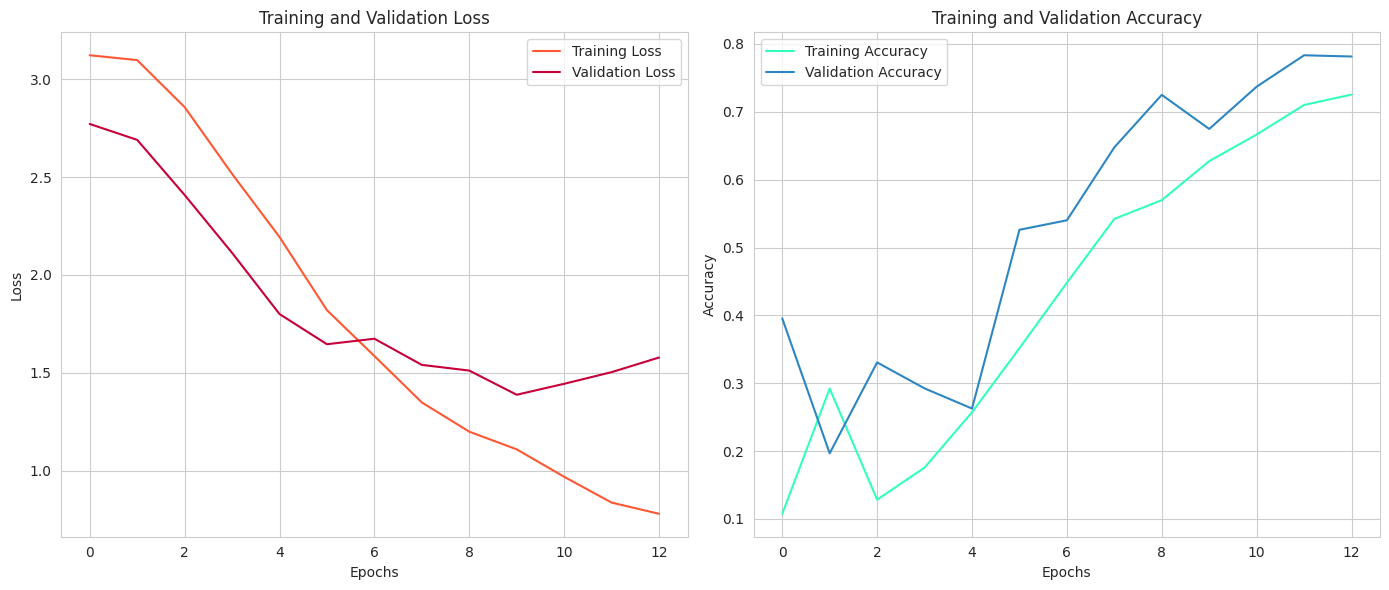

In [ ]:
sns.set_style("whitegrid")
# Traccia la perdita e l'accuratezza
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Loss
axes[0].plot(history_lstm.history['loss'], label='Training Loss', color='#FF5733')
axes[0].plot(history_lstm.history['val_loss'], label='Validation Loss', color='#C70039')
axes[0].set_title('Training and Validation Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()

# Accuracy
axes[1].plot(history_lstm.history['accuracy'], label='Training Accuracy', color='#33FFBD')
axes[1].plot(history_lstm.history['val_accuracy'], label='Validation Accuracy', color='#2E86C1')
axes[1].set_title('Training and Validation Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.tight_layout()
plt.show()


##Evaluation


In [ ]:
# Valutazione sul set di validazione
print("Validation Set Evaluation:")
val_loss_lstm, val_accuracy_lstm = model_lstm.evaluate(X_val, y_val, batch_size=32)
print(f"Validation Loss: {val_loss_lstm:.4f}")
print(f"Validation Accuracy: {val_accuracy_lstm:.4f}")

Validation Set Evaluation:
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6726 - loss: 1.5988
Validation Loss: 1.3879
Validation Accuracy: 0.6748


We analyze the model's performance on the test set by decoding sequences and labels to compare the true values with the predictions. The confusion matrix visualizes results for each class, highlighting the model's strengths and weaknesses. Finally, we compute the loss and accuracy on the test set to provide an overall evaluation of performance.

In [ ]:
# Costruzione di id_to_tag
id_to_tag_lstm = {i: tag for i, tag in enumerate(label_encoder.classes_)}

# Verifica di id_to_tag
print("id_to_tag:", id_to_tag_lstm)


id_to_tag: {0: 'B-Anatomical_system', 1: 'B-Cell', 2: 'B-Cellular_component', 3: 'B-Developing_anatomical_structure', 4: 'B-Immaterial_anatomical_entity', 5: 'B-Multi-tissue_structure', 6: 'B-Organ', 7: 'B-Organism_subdivision', 8: 'B-Organism_substance', 9: 'B-Pathological_formation', 10: 'B-Tissue', 11: 'I-Anatomical_system', 12: 'I-Cell', 13: 'I-Cellular_component', 14: 'I-Developing_anatomical_structure', 15: 'I-Immaterial_anatomical_entity', 16: 'I-Multi-tissue_structure', 17: 'I-Organ', 18: 'I-Organism_subdivision', 19: 'I-Organism_substance', 20: 'I-Pathological_formation', 21: 'I-Tissue', 22: 'O'}


In [ ]:
def decode_and_predict(X, y, model, tokenizer, id_to_tag):
    # Decodifica le sequenze di input
    X_decoded = [[tokenizer.index_word[token] for token in sentence if token != 0] for sentence in X]

    # Decodifica le etichette reali
    y_true_decoded = [[id_to_tag[np.argmax(tag)] for tag in sentence] for sentence in y]

    # Predizioni
    y_pred = model.predict(X)
    y_pred_decoded = [[id_to_tag[np.argmax(tag)] for tag in sentence] for sentence in y_pred]

    return X_decoded, y_true_decoded, y_pred_decoded



In [ ]:
def compute_class_metrics(y_true, y_pred, id_to_tag):
    # Flatten delle etichette
    y_true_flat = [tag for sentence in y_true for tag in sentence]
    y_pred_flat = [tag for sentence in y_pred for tag in sentence]

    # Calcolo del report
    report = classification_report(y_true_flat, y_pred_flat, target_names=list(id_to_tag.values()))
    print(report)


In [ ]:
def plot_conf_matrix(y_true, y_pred, id_to_tag):
    # Flatten delle etichette
    y_true_flat = [tag for sentence in y_true for tag in sentence]
    y_pred_flat = [tag for sentence in y_pred for tag in sentence]

    # Calcola la matrice di confusione
    conf_matrix = confusion_matrix(y_true_flat, y_pred_flat, labels=list(id_to_tag.values()))

    # Visualizza
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=list(id_to_tag.values()), yticklabels=list(id_to_tag.values()))
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()



Test Set Analysis:
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                                   precision    recall  f1-score   support

              B-Anatomical_system       0.03      0.91      0.06        11
                           B-Cell       0.15      0.60      0.24        96
             B-Cellular_component       0.02      0.48      0.04        25
B-Developing_anatomical_structure       0.40      0.91      0.56        11
   B-Immaterial_anatomical_entity       0.02      0.56      0.04         9
         B-Multi-tissue_structure       0.19      0.27      0.22        97
                          B-Organ       0.41      0.53      0.46        58
           B-Organism_subdivision       0.08      0.50      0.14        14
             B-Organism_substance       0.06      0.59      0.11        34
         B-Pathological_formation       0.08      0.50      0.14        48
                         B-Tissue       0.16      0.21      0.18        28
              I-Anatomical_system       0.03      0.80      0.05         5
                        

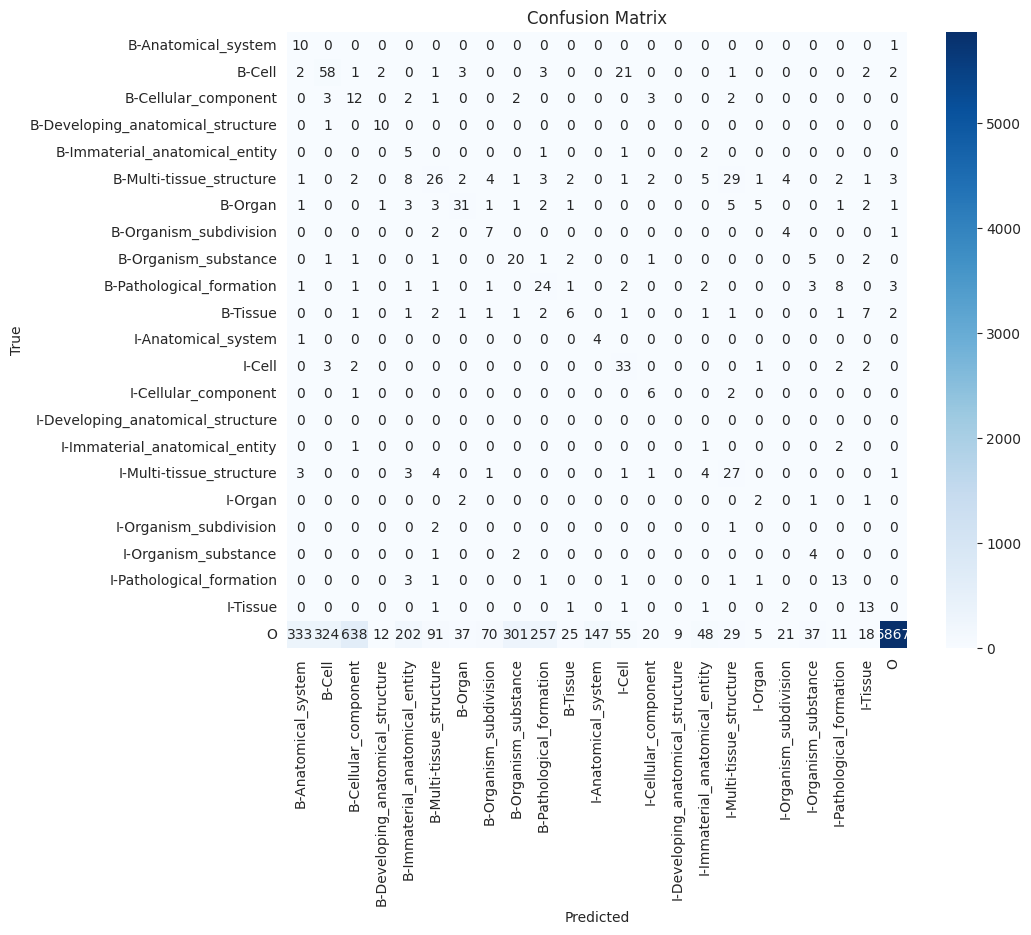

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6687 - loss: 1.2067

Test Loss: 1.3601
Test Accuracy: 0.6753


In [ ]:
# Analisi sul set di test
print("\nTest Set Analysis:")
X_test_decoded_lstm, y_test_decoded_lstm, y_pred_test_decoded_lstm = decode_and_predict(X_test, y_test, model_lstm, tokenizer, id_to_tag_lstm)
compute_class_metrics(y_test_decoded_lstm, y_pred_test_decoded_lstm, id_to_tag_lstm)
plot_conf_matrix(y_test_decoded_lstm, y_pred_test_decoded_lstm, id_to_tag_lstm)

# Accuratezza e perdita sul test set
test_loss_lstm, test_accuracy_lstm = model_lstm.evaluate(X_test, y_test, batch_size=32)
print(f"\nTest Loss: {test_loss_lstm:.4f}")
print(f"Test Accuracy: {test_accuracy_lstm:.4f}")


The LSTM model, with an overall **accuracy of 67.5%** on the test set and a **loss of 1.3601**, demonstrates good capabilities in leveraging sequential context but slightly underperforms compared to the LinearSVC, which achieved higher accuracy. This suggests that, while better suited to capturing relationships between tokens, the LSTM is more affected by the dataset imbalance.

Majority classes, such as 'O', achieve excellent results, with a precision of 1.00 and a recall of 69%. For example, the model correctly identifies most irrelevant tokens but occasionally overpredicts this class at the expense of others. For moderately represented classes, such as 'I-Cell', results are more balanced, with an F1-score of 0.41, indicating that the model can accurately recognize tokens associated with cells, albeit with some inaccuracies. Conversely, underrepresented classes, such as 'I-Developing_anatomical_structure' or 'I-Organism_subdivision', show a recall of 0.0, revealing that the model fails to learn effectively from the limited examples available for these categories. These results highlight the importance of implementing more advanced models to address the challenges posed by underrepresented classes.

#Prediction

We compare the predictions of our LSTM model with the true labels on the test set, showing concrete examples of tokens, true labels, and predicted labels.

In [ ]:
def predictions_lstm(model_lstm, X_test_lstm, Y_test_lstm, tokenizer, id_to_tag_lstm):
    token_lstm = [[tokenizer.index_word[token] for token in sentence if token != 0] for sentence in X_test_lstm]
    labels_lstm = [[id_to_tag_lstm[np.argmax(tag)] for tag in sentence] for sentence in Y_test_lstm]
    model_preds_lstm = [[id_to_tag_lstm[np.argmax(tag)] for tag in sentence] for sentence in model_lstm.predict(X_test_lstm)]
    return token_lstm, labels_lstm, model_preds_lstm


In [ ]:
# Predizioni sul test set
token_lstm, labels_lstm, model_preds_lstm = predictions_lstm(model_lstm, X_test, y_test, tokenizer, id_to_tag_lstm)

# Stampa esempi
for i, (token_lstm, label_lstm, model_pred_lstm) in enumerate(zip(token_lstm, labels_lstm, model_preds_lstm)):
    print(f"sentence: {i + 1}")
    print("Tokens:", " ".join(token_lstm))
    print("True Labels:", label_lstm)
    print("Predicted Labels:", model_pred_lstm)
    print("\n")
    if i == 5:  # Limita il numero di esempi stampati
        break


29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
sentence: 1
Tokens: lesions treated combined methods child died metastases brain obtained data
True Labels: ['B-Pathological_formation', 'O', 'O', 'O', 'O', 'O', 'B-Pathological_formation', 'B-Organ', 'O', 'O']
Predicted Labels: ['I-Pathological_formation', 'B-Pathological_formation', 'O', 'O', 'O', 'O', 'B-Pathological_formation', 'B-Organ', 'B-Pathological_formation', 'O']


sentence: 2
Tokens: loop derivative 6 forms homodimers steric reasons stoichiometric mixture open
True Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Predicted Labels: ['O', 'O', 'O', 'O', 'B-Cellular_component', 'B-Cellular_component', 'B-Cellular_component', 'B-Cellular_component', 'O', 'O']


sentence: 3
Tokens: finally understanding underlying mechanisms reduced bcm response inappropriate perinatal nutrition
True Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Predicted Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


sentence: 4
Token

#BiLSTM (Bidirectional Long Short Term Memory)

##Class weights and personalized loss
Before building the BiLSTM model, we addressed the class imbalance in the dataset by incorporating class weights into the loss function. This ensures that the model gives more attention to underrepresented classes during training. The custom loss function modifies the standard categorical cross-entropy by applying precomputed class weights to each token's loss. This approach helps the model learn patterns from all classes, even those with fewer examples, and reduces the negative impact of dataset imbalance.

In [ ]:
class_weights_tensor_bilstm = tf.constant(
    [class_weights_dict[i] for i in range(num_classes)],
    dtype=tf.float32
)


In [ ]:
def weighted_categorical_crossentropy_bilstm(y_true, y_pred):
    # Calcoliamo la crossentropia standard per ogni token
    cce = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    # cce: shape (batch, timesteps)

    # Ricaviamo la classe vera per ogni token
    y_true_classes = tf.argmax(y_true, axis=-1)  # shape (batch, timesteps)

    # Otteniamo i pesi per ogni token in base alla classe vera
    token_weights = tf.gather(class_weights_tensor_bilstm, y_true_classes)  # shape (batch, timesteps)

    # Moltiplichiamo la loss di ogni token per il corrispondente peso
    weighted_loss = cce * tf.cast(token_weights, tf.float32)

    # Ritorniamo la media della loss sul batch
    return tf.reduce_mean(weighted_loss)


##BiLSTM
The Bidirectional LSTM (BiLSTM) processes sequences in both forward and backward directions, capturing relationships within the data more effectively than standard LSTMs. By considering both preceding and following context, the BiLSTM provides a richer understanding of token dependencies and improves classification accuracy.
The model leverages a pre-trained embedding matrix to represent tokens in a semantic space, with the BiLSTM layer as the core component for bidirectional processing. Dropout is applied to reduce overfitting, and dense layers output probabilities for multi-class classification. To handle dataset imbalance, a custom loss function with class weights is used, while the Adam optimizer ensures efficient learning and stability.

In [ ]:
vocab_size_bilstm = embedding_matrix_lstm.shape[0]
model_bilstm = Sequential()
model_bilstm.add(Input(shape=(max_sequence_len,)))
model_bilstm.add(Embedding(
    input_dim=vocab_size_bilstm,
    output_dim=embedding_dim_lstm,
    weights=[embedding_matrix_lstm],
    input_length=max_sequence_len,
    mask_zero=True,
    trainable=True
))
model_bilstm.add(Bidirectional(LSTM(units=50, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)))
model_bilstm.add(Dense(num_classes, activation='softmax'))

# Compila il modello con la loss personalizzata
model_bilstm.compile(loss=weighted_categorical_crossentropy_bilstm, optimizer='adam', metrics=['accuracy'])
model_bilstm.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 10, 100)             │       1,152,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 10, 100)             │          60,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10, 23)              │           2,323 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,214,723 (4.63 MB)

 Trainable params: 1,214,723 (4.63 MB)

 Non-trainable params: 0 (0.00 B)

##Early stopping and checkpoint
As with the LSTM, we use the same callbacks, **ModelCheckpoint** and **EarlyStopping**, to monitor validation loss, save the best model, and prevent overfitting during the BiLSTM training process.


In [ ]:
best_model_file_bilstm = 'Bilstm-best-model-with-class-weights.keras'

checkpoint_bilstm = ModelCheckpoint(
    best_model_file_bilstm,
    save_weights_only=False,
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

early_stopping_bilstm = EarlyStopping(
    monitor="val_loss",
    min_delta=0.001,
    patience=3,
    verbose=1,
    mode="min",
    restore_best_weights=True
)

##Training
The BiLSTM training ran for up to 20 epochs with a batch size of 32. The **val_loss** consistently improved until **epoch 11**, reaching a minimum of **0.9089**. After three epochs without further progress, early stopping halted the process at epoch 14, restoring the best weights. Accuracy and loss indicate effective learning up to the saturation point of performance.

In [ ]:
history_bilstm = model_bilstm.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=20,
    verbose=1,
    callbacks=[checkpoint_bilstm, early_stopping_bilstm]
)

Epoch 1/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.1247 - loss: 2.9796
Epoch 1: val_loss improved from inf to 2.27205, saving model to Bilstm-best-model-with-class-weights.keras
134/134 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - accuracy: 0.1253 - loss: 2.9793 - val_accuracy: 0.3991 - val_loss: 2.2721
Epoch 2/20
133/134 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.4319 - loss: 2.3782
Epoch 2: val_loss improved from 2.27205 to 1.60306, saving model to Bilstm-best-model-with-class-weights.keras
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - accuracy: 0.4328 - loss: 2.3746 - val_accuracy: 0.5369 - val_loss: 1.6031
Epoch 3/20
133/134 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.5535 - loss: 1.5987
Epoch 3: val_loss improved from 1.60306 to 1.26642, saving model to Bilstm-best-model-with-class-weights.keras
134/134 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - accuracy: 0.5544 - loss: 1.5966 - val_accuracy: 0.6734 - val_loss: 1.2664
Epoch 4/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - 

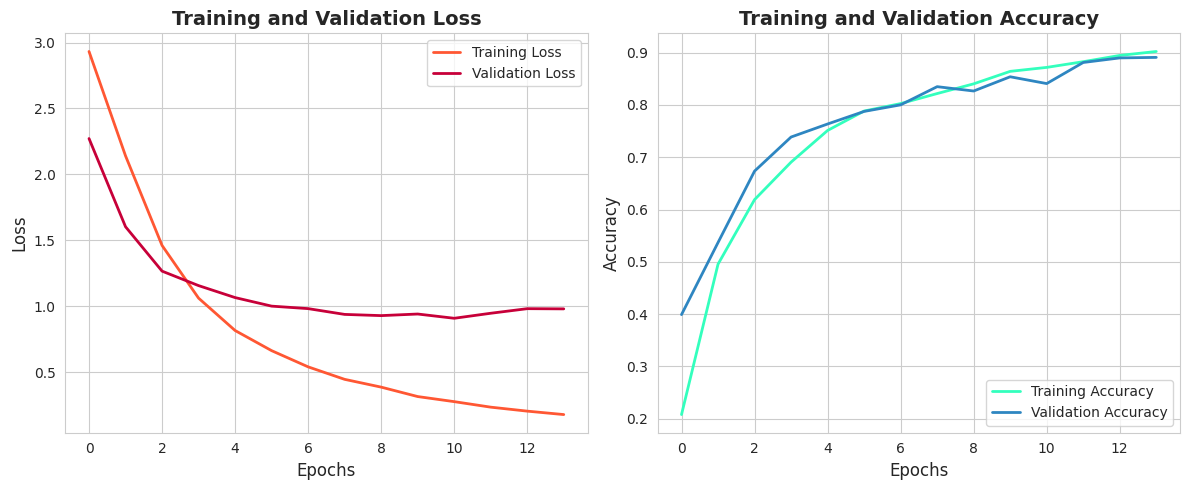

In [ ]:
# Imposta uno stile chiaro
sns.set_style("whitegrid")

# Definisci una palette di colori accesi
train_color_loss = '#FF5733'     # Arancione acceso per la training loss
val_color_loss = '#C70039'       # Rosso carico per la validation loss
train_color_acc = '#33FFBD'      # Verde acqua acceso per la training accuracy
val_color_acc = '#2E86C1'        # Blu brillante per la validation accuracy

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot della loss
axes[0].plot(history_bilstm.history['loss'], label='Training Loss', color=train_color_loss, linewidth=2)
axes[0].plot(history_bilstm.history['val_loss'], label='Validation Loss', color=val_color_loss, linewidth=2)
axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epochs', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].legend(loc='upper right', fontsize=10)

# Plot dell'accuracy
axes[1].plot(history_bilstm.history['accuracy'], label='Training Accuracy', color=train_color_acc, linewidth=2)
axes[1].plot(history_bilstm.history['val_accuracy'], label='Validation Accuracy', color=val_color_acc, linewidth=2)
axes[1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epochs', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].legend(loc='lower right', fontsize=10)

plt.tight_layout()
plt.show()


##Evalutaion
The BiLSTM model achieved an overall **accuracy of 84.82%** on the test set, showing a clear improvement over the LSTM. By leveraging bidirectional context, the BiLSTM improved precision and recall for several mid-represented classes, such as 'B-Organ' (F1-score 0.56) and 'I-Cell' (F1-score 0.55).
Majority classes like 'O' continue to perform exceptionally well, with an F1-score of 0.92, while underrepresented classes, such as 'I-Developing_anatomical_structure', still struggle, with precision and recall at 0.0. This highlights that class imbalance remains a challenge despite the overall progress.
In summary, the BiLSTM demonstrates better contextual understanding compared to the LSTM, delivering stronger performance overall.

In [ ]:
# Ottieni le predizioni dal modello
y_pred_bilstm = model_bilstm.predict(X_test)
y_pred_int_bilstm = y_pred_bilstm.argmax(axis=-1)  # converti in label IDs
y_true_int_bilstm = y_test.argmax(axis=-1)

# Ottieni i nomi delle classi
tag_names_bilstm = label_encoder.classes_

# Calcola l'accuracy a livello di token
accuracy_bilstm = accuracy_score(y_true_int_bilstm.flatten(), y_pred_int_bilstm.flatten())

print(f"Test Accuracy (BiLSTM): {round(accuracy_bilstm * 100, 2)}%\n")

# Classification report
report_bilstm = classification_report(
    y_true_int_bilstm.flatten(),
    y_pred_int_bilstm.flatten(),
    target_names=tag_names_bilstm
)
print(report_bilstm)


29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
Test Accuracy (BiLSTM): 84.82%

                                   precision    recall  f1-score   support

              B-Anatomical_system       0.11      0.91      0.19        11
                           B-Cell       0.35      0.78      0.48        96
             B-Cellular_component       0.11      0.60      0.19        25
B-Developing_anatomical_structure       0.53      0.91      0.67        11
   B-Immaterial_anatomical_entity       0.11      0.67      0.18         9
         B-Multi-tissue_structure       0.31      0.58      0.41        97
                          B-Organ       0.43      0.81      0.56        58
           B-Organism_subdivision       0.26      0.50      0.34        14
             B-Organism_substance       0.20      0.79      0.32        34
         B-Pathological_formation       0.14      0.69      0.23        48
                         B-Tissue       0.17      0.50      0.26        28
              I-Anatomical_

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


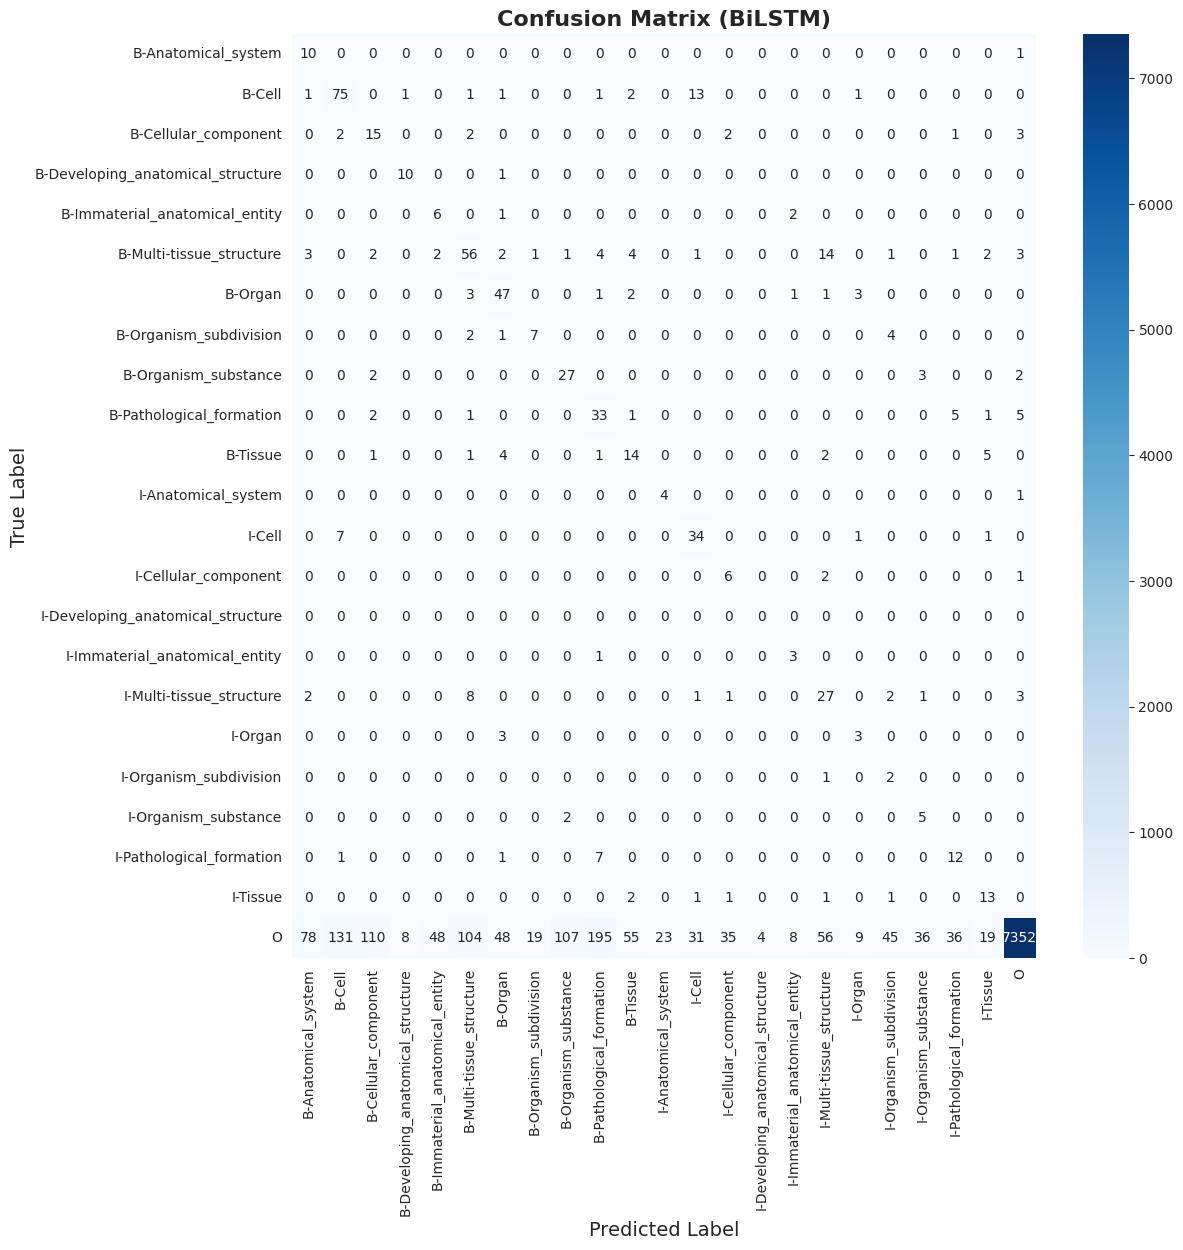

In [ ]:
cm_bilstm = confusion_matrix(y_true_int_bilstm.flatten(), y_pred_int_bilstm.flatten())

plt.figure(figsize=(12,12))
sns.heatmap(cm_bilstm, annot=True, fmt='d', cmap='Blues',
            xticklabels=tag_names_bilstm,
            yticklabels=tag_names_bilstm)
plt.title('Confusion Matrix (BiLSTM)', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.show()


##Prediction
In this phase, we analyze test sequences by comparing the original tokens, true labels, and predicted labels. This qualitative evaluation helps identify specific strengths and weaknesses of the model.
In the first example, the model correctly identifies entities like 'B-Pathological_formation' and 'B-Organ' but struggles with boundary distinctions, confusing 'B-Pathological_formation' with 'I-Pathological_formation'. In subsequent examples, where most tokens belong to the majority class 'O', the model performs well, showcasing strong classification capabilities for well-represented classes. However, errors such as predicting 'B-Cellular_component' instead of 'O' in example 4 reveal challenges in handling less frequent or ambiguous entities.
This qualitative evaluation complements the metrics by offering insights into the model's behavior and highlighting areas to improve predictions for challenging or rare classes.

In [ ]:
def decode_tokens_bilstm(sequence, tokenizer):
    # Ignora i padding (ID = 0)
    return [tokenizer.index_word[idx] for idx in sequence if idx != 0]

# Previsione sul test set
y_pred_bilstm = model_bilstm.predict(X_test)
y_pred_int_bilstm = np.argmax(y_pred_bilstm, axis=-1)   # (num_seq, max_seq_len)
y_true_int_bilstm = np.argmax(y_test, axis=-1)   # (num_seq, max_seq_len)

tag_names_bilstm = label_encoder.classes_

# Mostriamo le prime 5 sequenze di test
for i in range(5):
    tokens_bilstm = decode_tokens_bilstm(X_test[i], tokenizer)
    # Prendiamo la lunghezza effettiva della sequenza (senza padding)
    seq_len_bilstm = len(tokens_bilstm)

    # Convertiamo le etichette vere e predette in formato testuale
    true_labels_bilstm = [tag_names_bilstm[label_id] for label_id in y_true_int_bilstm[i][:seq_len_bilstm]]
    pred_labels_bilstm = [tag_names_bilstm[label_id] for label_id in y_pred_int_bilstm[i][:seq_len_bilstm]]

    print("Sequence:", i+1)
    print("Tokens: ", tokens_bilstm)
    print("True:   ", true_labels_bilstm)
    print("Pred:   ", pred_labels_bilstm)
    print("\n")

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Sequence: 1
Tokens:  ['lesions', 'treated', 'combined', 'methods', 'child', 'died', 'metastases', 'brain', 'obtained', 'data']
True:    ['B-Pathological_formation', 'O', 'O', 'O', 'O', 'O', 'B-Pathological_formation', 'B-Organ', 'O', 'O']
Pred:    ['I-Pathological_formation', 'O', 'O', 'O', 'O', 'B-Pathological_formation', 'B-Pathological_formation', 'B-Organ', 'O', 'O']


Sequence: 2
Tokens:  ['loop', 'derivative', '6', 'forms', 'homodimers', 'steric', 'reasons', 'stoichiometric', 'mixture', 'open']
True:    ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Pred:    ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


Sequence: 3
Tokens:  ['finally', 'understanding', 'underlying', 'mechanisms', 'reduced', 'bcm', 'response', 'inappropriate', 'perinatal', 'nutrition']
True:    ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Pred:    ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


Sequence: 4
Tokens:  ['c', 'isotope', 'signals', 'plant', 't

#GRU (Gated Recurrent Unit)
The Gated Recurrent Unit (GRU) is a recurrent neural network architecture similar to LSTM but with a simplified structure. GRUs combine the input and forget gates into a single update gate, reducing the number of parameters and computational time. This makes GRUs faster and more efficient, particularly suitable for scenarios where computational resources are limited or datasets are smaller.
The overall structure of this model is similar to the LSTM, with the key difference being the GRU layer, which processes sequential data while retaining relevant context. Pre-trained GloVe embeddings are used for token representation, and a final Dense layer with softmax activation outputs the classification probabilities. Additionally, a custom weighted loss function addresses class imbalance, ensuring better performance across all categories.

##Class weights and weighted  Crossentropy Loss
As with previous models, a weighted loss function was defined to assign greater importance to underrepresented classes. The weights, computed based on class distribution, scale the loss for each token, encouraging the model to improve predictions for minority classes.

In [ ]:
# Convertiamo class_weights_dict in un tensore
class_weights_tensor_gru = tf.constant(
    [class_weights_dict[i] for i in range(num_classes)],
    dtype=tf.float32
)

def weighted_categorical_crossentropy_gru(y_true, y_pred):

    # Calcoliamo la crossentropia standard per ogni token
    cce = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    # cce: shape (batch, timesteps)

    # Ricaviamo la classe vera per ogni token
    y_true_classes = tf.argmax(y_true, axis=-1)  # shape (batch, timesteps)

    # Otteniamo i pesi per ogni token in base alla classe vera
    token_weights = tf.gather(class_weights_tensor_gru, y_true_classes)  # shape (batch, timesteps)

    # Moltiplichiamo la loss di ogni token per il corrispondente peso
    weighted_loss = cce * tf.cast(token_weights, tf.float32)

    # Ritorniamo la media della loss sul batch
    return tf.reduce_mean(weighted_loss)


In [ ]:
vocab_size_gru = embedding_matrix_lstm.shape[0]
embedding_dim_gru = embedding_matrix_lstm.shape[1]
max_sequence_len_gru = X_train.shape[1]

num_units = 50
# num_classes già definito in precedenza come len(label_encoder.classes_)

model_gru = Sequential()
model_gru.add(Input(shape=(max_sequence_len,)))
model_gru.add(Embedding(
    input_dim=vocab_size_gru,
    output_dim=embedding_dim_gru,
    weights=[embedding_matrix_lstm],
    input_length=max_sequence_len_gru,
    mask_zero=True,
    trainable=True
))
model_gru.add(GRU(units=num_units, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model_gru.add(Dense(num_classes, activation='softmax'))

model_gru.compile(loss=weighted_categorical_crossentropy_gru, optimizer='adam', metrics=['accuracy'])
model_gru.summary()



/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, 10, 100)             │       1,152,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 10, 50)              │          22,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10, 23)              │           1,173 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,175,973 (4.49 MB)

 Trainable params: 1,175,973 (4.49 MB)

 Non-trainable params: 0 (0.00 B)

##Early stopping, ModelCheckpoint and Training
The GRU model was trained for 20 epochs with a batch size of 32, utilizing early stopping to prevent overfitting and **ModelCheckpoint** to save the best model based on validation loss. During training, the model exhibited a steady reduction in loss and an increase in accuracy, achieving a minimum validation **loss of 0.93399**  and a validation **accuracy of 87.1%** at epoch 11, where early stopping terminated the process.

In [ ]:
best_model_file_gru = 'GRU-best-model-with-class-weights.keras'

checkpoint_gru = ModelCheckpoint(
    best_model_file_gru,
    save_weights_only=False,
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

early_stopping_gru = EarlyStopping(
    monitor="val_loss",
    min_delta=0.001,
    patience=3,
    verbose=1,
    mode="min",
    restore_best_weights=True
)

history_gru = model_gru.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=20,
    verbose=1,
    callbacks=[checkpoint_gru, early_stopping_gru]
)

Epoch 1/20
133/134 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.1045 - loss: 2.8589
Epoch 1: val_loss improved from inf to 2.34786, saving model to GRU-best-model-with-class-weights.keras
134/134 ━━━━━━━━━━━━━━━━━━━━ 11s 50ms/step - accuracy: 0.1062 - loss: 2.8605 - val_accuracy: 0.5172 - val_loss: 2.3479
Epoch 2/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.5229 - loss: 2.5777
Epoch 2: val_loss improved from 2.34786 to 1.88593, saving model to GRU-best-model-with-class-weights.keras
134/134 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.5231 - loss: 2.5761 - val_accuracy: 0.6403 - val_loss: 1.8859
Epoch 3/20
133/134 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6464 - loss: 1.9280
Epoch 3: val_loss improved from 1.88593 to 1.51168, saving model to GRU-best-model-with-class-weights.keras
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.6465 - loss: 1.9269 - val_accuracy: 0.6809 - val_loss: 1.5117
Epoch 4/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy:

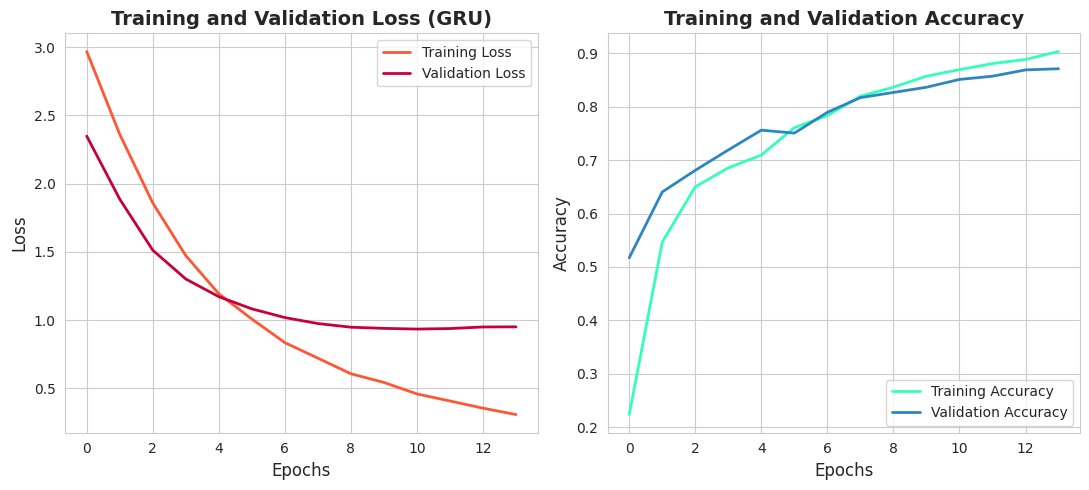

In [ ]:
sns.set_style("whitegrid")

train_color_loss = '#FF5733'
val_color_loss = '#C70039'
train_color_acc = '#33FFBD'
val_color_acc = '#2E86C1'

fig, axes = plt.subplots(1, 2, figsize=(11, 5))

# Andamento Loss
axes[0].plot(history_gru.history['loss'], label='Training Loss', color=train_color_loss, linewidth=2)
axes[0].plot(history_gru.history['val_loss'], label='Validation Loss', color=val_color_loss, linewidth=2)
axes[0].set_title('Training and Validation Loss (GRU)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epochs', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].legend(loc='upper right', fontsize=10)

# Andamento Accuracy
axes[1].plot(history_gru.history['accuracy'], label='Training Accuracy', color=train_color_acc, linewidth=2)
axes[1].plot(history_gru.history['val_accuracy'], label='Validation Accuracy', color=val_color_acc, linewidth=2)
axes[1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epochs', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].legend(loc='lower right', fontsize=10)

plt.tight_layout()
plt.show()


##Evaluation
The GRU model achieved an overall **accuracy of 84.94%** on the test set, demonstrating strong performance in predicting majority classes such as 'O,' which attained an F1-score of 0.93. This indicates the model’s ability to identify tokens that do not belong to any specific entity. For moderately represented classes, such as 'B-Organ' and 'B-Multi-tissue_structure,' the F1-scores of 0.61 and 0.44 highlight the GRU’s capacity to capture relevant patterns, albeit with room for improvement in precision and recall.
However, the model struggled with underrepresented classes like 'I-Developing_anatomical_structure,' where no true positives were recorded, leading to an F1-score of 0.0. This underscores the persistent challenge of handling rare categories effectively, even with the inclusion of a weighted loss function.
Overall, the GRU model balances computational efficiency with robust performance on majority and moderately frequent classes but continues to face limitations in recognizing rare or complex patterns.

In [ ]:
y_pred_gru = model_gru.predict(X_test)
y_pred_int_gru = y_pred_gru.argmax(axis=-1)
y_true_int_gru = y_test.argmax(axis=-1)

tag_names_gru = label_encoder.classes_

accuracy_gru = accuracy_score(y_true_int_gru.flatten(), y_pred_int_gru.flatten())
print(f"Test Accuracy (GRU): {round(accuracy_gru * 100, 2)}%\n")

report_gru= classification_report(y_true_int_gru.flatten(), y_pred_int_gru.flatten(), target_names=tag_names_gru)
print(report_gru)


29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Test Accuracy (GRU): 84.94%

                                   precision    recall  f1-score   support

              B-Anatomical_system       0.09      1.00      0.16        11
                           B-Cell       0.34      0.76      0.47        96
             B-Cellular_component       0.10      0.52      0.17        25
B-Developing_anatomical_structure       0.35      1.00      0.52        11
   B-Immaterial_anatomical_entity       0.12      0.56      0.20         9
         B-Multi-tissue_structure       0.38      0.53      0.44        97
                          B-Organ       0.51      0.76      0.61        58
           B-Organism_subdivision       0.15      0.79      0.25        14
             B-Organism_substance       0.25      0.74      0.38        34
         B-Pathological_formation       0.15      0.58      0.24        48
                         B-Tissue       0.20      0.36      0.26        28
              I-Anatomical_sys

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


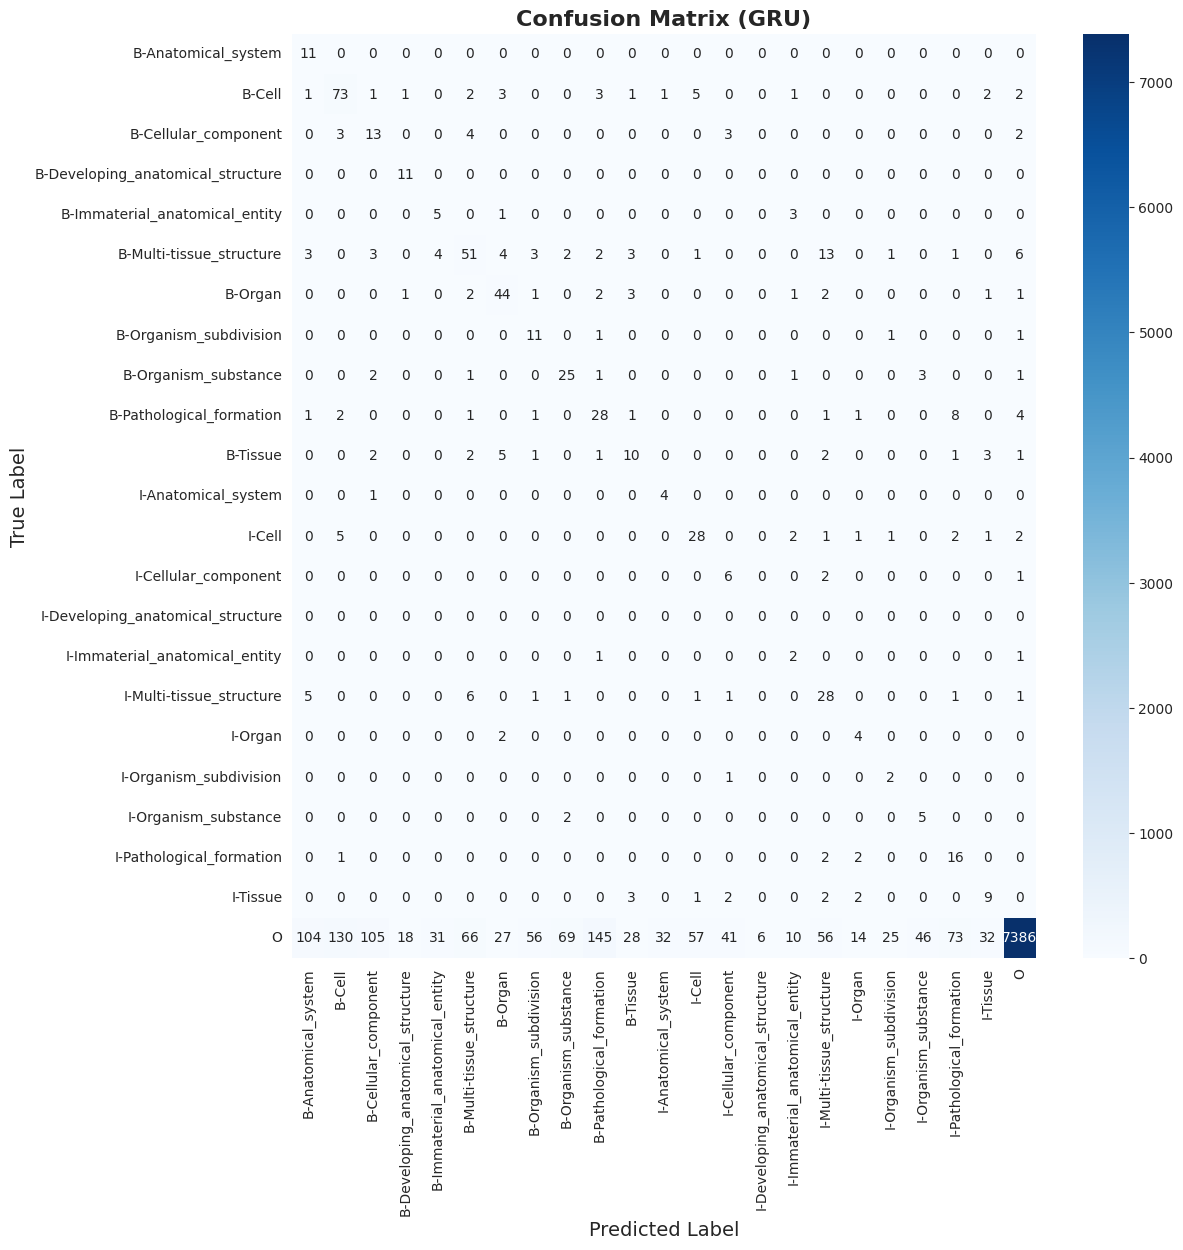

In [ ]:
# Creiamo la confusion matrix
cm_gru = confusion_matrix(y_true_int_gru.flatten(), y_pred_int_gru.flatten())

plt.figure(figsize=(12,12))
sns.heatmap(cm_gru, annot=True, fmt='d', cmap='Blues',
            xticklabels=tag_names_gru, yticklabels=tag_names_gru)
plt.title('Confusion Matrix (GRU)', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.show()


#Prediction
By examining the GRU model's predictions on specific test sequences, we gain insight into its ability to capture contextual information and make accurate classifications at the token level. For example, the model often identifies entities like organs or tissues correctly, such as labeling "brain" as B-Organ or "tissues" as B-Tissue. However, it occasionally misclassifies surrounding tokens, reflecting its difficulty in maintaining consistency within sequences.
The GRU sometimes predicts entities for irrelevant terms, such as labeling "steric" as part of a cellular component. These instances reveal challenges in distinguishing subtle differences between domain-specific terminology and unrelated tokens. This analysis provides a deeper understanding of the model's decision-making process and highlights the need for further optimization to enhance precision and handle rare or ambiguous cases effectively.

In [ ]:
def decode_tokens_gru(sequence, tokenizer):
    return [tokenizer.index_word[idx] for idx in sequence if idx != 0]

for i in range(5):
    tokens_gru = decode_tokens_gru(X_test[i], tokenizer)
    seq_len_gru = len(tokens_gru)

    true_labels_gru = [tag_names_gru[lid] for lid in y_true_int_gru[i][:seq_len_gru]]
    pred_labels_gru = [tag_names_gru[lid] for lid in y_pred_int_gru[i][:seq_len_gru]]

    print("Sequence:", i+1)
    print("Tokens: ", tokens_gru)
    print("True:   ", true_labels_gru)
    print("Pred:   ", pred_labels_gru)
    print("\n")


Sequence: 1
Tokens:  ['lesions', 'treated', 'combined', 'methods', 'child', 'died', 'metastases', 'brain', 'obtained', 'data']
True:    ['B-Pathological_formation', 'O', 'O', 'O', 'O', 'O', 'B-Pathological_formation', 'B-Organ', 'O', 'O']
Pred:    ['I-Pathological_formation', 'O', 'O', 'O', 'O', 'O', 'B-Pathological_formation', 'B-Organ', 'O', 'O']


Sequence: 2
Tokens:  ['loop', 'derivative', '6', 'forms', 'homodimers', 'steric', 'reasons', 'stoichiometric', 'mixture', 'open']
True:    ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Pred:    ['O', 'O', 'O', 'O', 'O', 'B-Cellular_component', 'O', 'O', 'O', 'O']


Sequence: 3
Tokens:  ['finally', 'understanding', 'underlying', 'mechanisms', 'reduced', 'bcm', 'response', 'inappropriate', 'perinatal', 'nutrition']
True:    ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Pred:    ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


Sequence: 4
Tokens:  ['c', 'isotope', 'signals', 'plant', 'tissues', 'key', 'tool', 'explaining', 'grow

#Model comparisons
In this final phase, we compared the performance of Linear SVC, LSTM, BiLSTM, and GRU using key metrics like accuracy, macro-averaged F1-score, recall, and precision. This overview highlights each model’s strengths and weaknesses, offering insights into their effectiveness for multi-label token classification.

The Linear SVC achieves an accuracy of 77.27%, with strong macro precision (68.86%), but struggles with recall, indicating difficulties in handling underrepresented classes. Its lack of sequence-awareness limits its ability to leverage context, which is crucial for tasks involving token classification.

The LSTM, while designed to capture sequential dependencies, achieves lower accuracy (67.53%) and macro F1-score. Despite its ability to process sequence data, its performance is hindered by the dataset imbalance and the complexity of capturing long-range dependencies effectively.

The BiLSTM delivers a notable improvement, achieving an accuracy of 84.82% and excelling in macro recall (66.69%), thanks to its ability to consider both past and future contexts. This makes it well-suited for handling intricate relationships in sequential data.

The GRU slightly edges out the BiLSTM with an accuracy of 84.94%. Its streamlined architecture offers computational efficiency, while maintaining strong performance. However, its macro F1-score suggests that it could still be optimized for underrepresented classes.

Overall, the GRU emerges as the best-performing model in terms of accuracy and efficiency. However, the BiLSTM’s ability to capture bidirectional context makes it particularly effective for complex sequential tasks, highlighting the importance of model selection based on the task’s requirements.

In [ ]:
# Metrics for Multi-Label Classification
accuracy_lsvc = metrics.accuracy_score(y_test_multi, predictions_multi)  # Exact Match Accuracy
f1_score_macro_lsvc = metrics.f1_score(y_test_multi, predictions_multi, average='macro')
precision_macro_lsvc = metrics.precision_score(y_test_multi, predictions_multi, average='macro', zero_division=0)
recall_macro_lsvc = metrics.recall_score(y_test_multi, predictions_multi, average='macro', zero_division=0)

# Assicurati che i dati siano array NumPy
y_test_decoded_lstm_np = np.array([item for sublist in y_test_decoded_lstm for item in sublist])
y_pred_test_decoded_lstm_np = np.array([item for sublist in y_pred_test_decoded_lstm for item in sublist])

y_true_int_bilstm_np = np.array(y_true_int_bilstm).flatten()
y_pred_int_bilstm_np = np.array(y_pred_int_bilstm).flatten()

y_true_int_gru_np = np.array(y_true_int_gru).flatten()
y_pred_int_gru_np = np.array(y_pred_int_gru).flatten()

# Compute the F1 score macro average for the 3 models
f1_score_macro_lstm = metrics.f1_score(y_test_decoded_lstm_np, y_pred_test_decoded_lstm_np, average='macro', zero_division=0)
f1_score_macro_bilstm = metrics.f1_score(y_true_int_bilstm_np, y_pred_int_bilstm_np, average='macro', zero_division=0)
f1_score_macro_gru = metrics.f1_score(y_true_int_gru_np, y_pred_int_gru_np, average='macro', zero_division=0)

# Compute the Recall macro average for the 3 models
recall_macro_lstm = metrics.recall_score(y_test_decoded_lstm_np, y_pred_test_decoded_lstm_np, average='macro', zero_division=0)
recall_macro_bilstm = metrics.recall_score(y_true_int_bilstm_np, y_pred_int_bilstm_np, average='macro', zero_division=0)
recall_macro_gru = metrics.recall_score(y_true_int_gru_np, y_pred_int_gru_np, average='macro', zero_division=0)

# Compute the Precision macro average for the 3 models
precision_macro_lstm = metrics.precision_score(y_test_decoded_lstm_np, y_pred_test_decoded_lstm_np, average='macro', zero_division=0)
precision_macro_bilstm = metrics.precision_score(y_true_int_bilstm_np, y_pred_int_bilstm_np, average='macro', zero_division=0)
precision_macro_gru = metrics.precision_score(y_true_int_gru_np, y_pred_int_gru_np, average='macro', zero_division=0)

# Make a table for an overview of the performances
data = {
    'Metric': ['Accuracy', 'F1 Score Macro', 'Recall Macro', 'Precision Macro'],
    'Linear SVC': [accuracy_lsvc, f1_score_macro_lsvc, recall_macro_lsvc, precision_macro_lsvc],
    'LSTM': [test_accuracy_lstm, f1_score_macro_lstm, recall_macro_lstm, precision_macro_lstm],
    'BiLSTM': [accuracy_bilstm, f1_score_macro_bilstm, recall_macro_bilstm, precision_macro_bilstm],
    'GRU': [accuracy_gru, f1_score_macro_gru, recall_macro_gru, precision_macro_gru]
}

evaluation_tab = pd.DataFrame(data)
evaluation_tab_transposed = evaluation_tab.set_index('Metric').T

# Visualizziamo la tabella
display(evaluation_tab_transposed)



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Metric      Accuracy  F1 Score Macro  Recall Macro  Precision Macro
Linear SVC  0.772678        0.464828      0.370571         0.688644
LSTM        0.675301        0.230431      0.523509         0.182002
BiLSTM      0.848197        0.336428      0.666892         0.249800
GRU         0.849399        0.306016      0.650794         0.226196